## Notebook for exploring the MAE of the visual features
#### Outline
-  Prepare data
    - Load model from checkpoint
    - Get image representations from iNaturalist validation dataset
- Exploring latent space of MAE model

In [1]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from util.pos_embed import interpolate_pos_embed
import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.19.5
1.2.0
1.10.2+cu113


# Get Embedding
- from iNaturelist 2021 validation dataset
    - size: 15k
- encoder 
    - MAE encoder
    - ViT from Fine-tune of MAE encoder 

### Load encoder

In [16]:
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'iNat' #  'iNat', 'eBird'

ck_iNat_FT = 'ebird_FT_cls_vit_base_checkpoint-99.pth'       #　iNaturalist finetuned MAE
ck_eBird_PT = 'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　Ebird pretrained MAE

model_data_version = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {model_data_version}')
 

Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_iNat(Data)


In [17]:
def load_encoder(nb_classes:int=1486, global_pool:bool=False, encoder_version:str='iNat_FT', **kwargs):
    assert encoder_version == 'eBirdPT' or encoder_version =='iNatFT', f'Encoder_version must be either iNatFT or eBirdPT, got {encoder_version}'
    
    print(f'Encoder  : {encoder_version}')
    if encoder_version=='iNatFT':
        ck = Path('output_dir')/ck_iNat_FT 
    elif encoder_version=='eBirdPT':
        ck = Path('output_dir')/ck_eBird_PT
        
    model = models_vit.__dict__['vit_base_patch16'](
        num_classes=nb_classes, global_pool=global_pool, )
    checkpoint = torch.load(ck, map_location='cpu')
    

    print(f"Load pre-trained checkpoint from: {ck}")
    checkpoint_model = checkpoint['model']

    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

encoder = load_encoder(encoder_version=encoder_version)



Encoder  : iNatFT
Load pre-trained checkpoint from: output_dir/ebird_FT_cls_vit_base_checkpoint-99.pth
<All keys matched successfully>


### Prepare dataset

In [18]:
if data_src == 'eBird':
    val_data = 'val_ebird'
elif data_src == 'iNat':
    val_data = 'val'
    
# simple augmentation
transform_toTensor = transforms.Compose([
                    transforms.Resize(256, interpolation=3),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()
                        ])
#dataset_train = datasets.ImageFolder(os.path.join(args.data_path), transform=transform_train)
data_path = '../../share/iNaturalist_2021'
dataset = datasets.ImageFolder(os.path.join(data_path,  val_data), transform=transform_toTensor)
print(dataset)

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False,
        num_workers=8,  batch_size=100,)

Dataset ImageFolder
    Number of datapoints: 14860
    Root location: ../../share/iNaturalist_2021/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


### Get Embedding

In [19]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)

start_time = time.time()
for i, (images, *_) in enumerate(data_loader):

    images = images.to(device)
    
    with torch.no_grad():
        embedding_ = encoder.forward_features(images)
        # embedding_ = embedding_.detach().cpu().numpy()

    if i == 0 :
        embeddings = embedding_
    else:
        embeddings = torch.cat((embeddings, embedding_), axis=0)    
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Progress:{i+1:4d}, {100*(i+1)/len(data_loader):3.2f}%. ' 
    info += f'| Feature_shape: {embeddings.shape}.' 
    info += f'| Time: {passing_time}. '
    print(info, end='\r')

#     if i==3:
#         break


CPU times: user 57.7 s, sys: 2.2 s, total: 59.9 sze([14860, 768]).| Time: 0:00:57. 
Wall time: 57.5 s


In [20]:

file_ = f'embeddings_iNatureVal_{encoder_version}_{data_src}.npz'

np.savez_compressed(path_embeddings/file_, embedding=embeddings.cpu().numpy() )
print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)

# df_embedding = pd.DataFrame(embeddings)
# df_embedding

embeddings_iNatureVal_iNatFT_iNat.npz saved
(14860, 768)


In [11]:
df_embedding = pd.DataFrame(embeddings)
df_embedding
df_dim_stat = pd.DataFrame(columns=['mean', 'std', 'min', 'max'])
df_dim_stat  = (pd.concat([df_embedding.mean(), df_embedding.std(), df_embedding.min(), df_embedding.max()], axis=1)
            .set_axis(['mean', 'std', 'min', 'max'], axis=1)
            )
df_dim_stat


,mean,std,min,max
0,-0.028391,0.125723,-0.505754,0.616572
1,0.146592,0.143200,-0.438574,0.731668
2,0.047031,0.161215,-0.596715,0.847233
3,0.028699,0.155817,-0.587634,0.963721
4,0.255339,0.179817,-0.536862,0.981763
...,...,...,...,...
763,-0.184352,0.153128,-0.884072,0.623796
764,-0.039063,0.141105,-0.757738,0.525678
765,-0.016714,0.139588,-0.638736,0.530903
766,0.075813,0.155598,-0.660312,0.927093


## Embedding Distribution

In [42]:
figsize=(6,3)
title = f'EmbeddingDistribution\n{model_data_version}'
print(title)

EmbeddingDistribution
MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_eBird(Data)


In [ ]:
# df_dim_stat.plot(kind='box',figsize=figsize, title=title, ylim=(-10,10));
# (df_dim_stat[['mean',
#               'max','min'
#               ]]
#  .plot(grid=True, figsize=figsize, title=title,
#      kind='hist', bins=200, logy=True, alpha=0.5,
#        xlim=(-10,10),                     
#                                        ));

In [ ]:
# figsize=(21,3)
# ax = (df_dim_stat.reset_index().rename(columns={'index':'dim'})
#  .plot.scatter(x='dim', y='mean', label='Mean',  
#      figsize=figsize, title=title, ylim=(-2,2), xlim=(0,768), grid=True)
#  )
# figsize=(21,3)
# (df_dim_stat.reset_index().rename(columns={'index':'dim'})
#  .plot.scatter(x='dim', y='std', label='Std',
#      figsize=figsize, title=title, xlim=(0,768), grid=True, c='orange', alpha=0.5,ax=ax)
#  );



In [24]:
print(f'{encoder_version.upper()}_{token}')
df_dim_stat.query('mean > 0.5 or mean <-0.5')

EBIRD_PT_cls


,mean,std,min,max
149,0.740037,0.375925,-0.601547,2.140704
317,0.855858,0.130661,0.428169,1.561652
325,-14.072468,0.546277,-16.046907,-10.586195
406,0.592931,0.106390,0.097207,1.212032
417,-3.110582,0.007675,-3.149565,-3.074161
582,0.534365,0.124251,0.053976,1.031261
653,0.506571,0.072211,0.202528,0.758470
666,0.777518,0.101676,0.366765,1.277196
723,-0.921817,0.196540,-1.540325,0.002440


#### plot density distribution(all dims)

CPU times: user 1.68 s, sys: 148 ms, total: 1.83 s
Wall time: 1.65 s


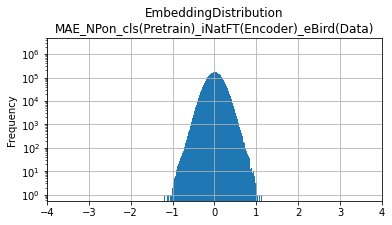

In [44]:
%%time

title = f'EmbeddingDistribution\n{model_data_version}'

figsize = (6,3)
xlim=(-4,4)
ylim=(0,5e6)

fig = (df_embedding.stack().plot
       .hist(bins=500, figsize=figsize, title=title, grid=True, xlim=xlim, ylim=ylim, logy=True)
      ).get_figure()
fig.savefig(path_embeddings/f'{title}_hist.jpg')



#### plot density distribution(dims with diff. color) 

CPU times: user 2min 37s, sys: 1.69 s, total: 2min 38s
Wall time: 2min 38s


<AxesSubplot:title={'center':'Embedding Distribution_EBIRD_PT_cls_ebird'}, ylabel='Frequency'>

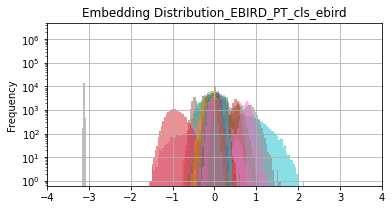

In [32]:
%%time
(df_embedding.plot
   .hist(bins=500, figsize=figsize, title=title, grid=True, 
         legend=False,  logy=True, alpha=0.5,
         ylim=ylim,xlim=xlim,)
    .savefig(path_embeddings/f'{title}_multi.jpg')
      )


## Correlation btw Dimmensions

In [16]:
%%time
# matrix = df_embedding.corr()  # 13.8 s
corr_matrix = np.corrcoef(df_embedding.T)
print(corr_matrix.shape)

(768, 768)
CPU times: user 679 ms, sys: 903 ms, total: 1.58 s
Wall time: 155 ms


CPU times: user 989 ms, sys: 460 ms, total: 1.45 s
Wall time: 889 ms


''

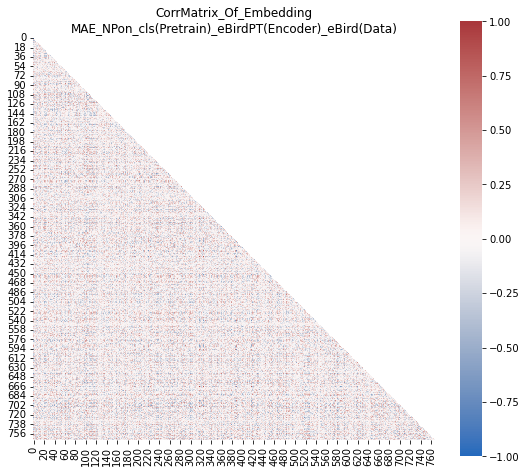

In [17]:
%%time

# 取矩陣下半三角形
mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

title = f'CorrMatrix_Of_Embedding\n{model_data_version}'
fig, ax = plt.subplots(figsize=(9, 8) )
ax.set_title(title)
sns.heatmap(corr_matrix, vmax=1, vmin=-1, center=0, square=True, 
            mask=mask,
            cmap='vlag', ax=ax)
fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
;

/home/ess/anaconda3/envs/bury_beetles/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:503: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


''

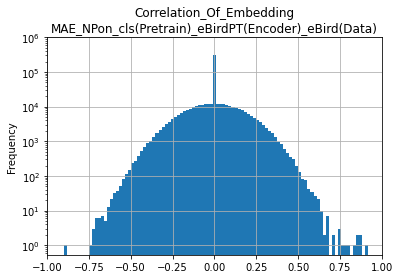

In [18]:
title = f'Correlation_Of_Embedding\n{model_data_version}'

xlim=(-1,1)
ylim=(0,1e6)
# k=-1 ，排除斜對角的數值(均為1.0) 
fig = (pd.DataFrame(np.tril(corr_matrix ,k=-1))
       .stack()
       .plot(kind='hist', title=title, bins=100, grid=True, logy=True, xlim=xlim, ylim=ylim)
      ).get_figure()
fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
;

## Visualization of Embeddings by dimension reduction

### 2D繪圖

#### load embedding

In [156]:
# load embedding
encoder_version='eBirdPT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBird' #  'iNat', 'eBird'

file_ = f'embeddings_iNatureVal_{encoder_version}_{data_src}.npz'

embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)


(14860, 768)


In [7]:
import umap

In [8]:
seed=0
n_neighbors=500
n_components=2
metric= 'euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)

In [9]:
%%time
print(embeddings.shape)
embedding_umap = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

(14860, 768)
UMAP(dens_frac=0.0, dens_lambda=0.0, n_neighbors=500, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Fri May 27 13:56:16 2022 Finding Nearest Neighbors
Fri May 27 13:56:16 2022 Building RP forest with 11 trees
Fri May 27 13:56:16 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	 8  /  14
	Stopping threshold met -- exiting after 8 iterations
Fri May 27 13:57:01 2022 Finished Nearest Neighbor Search
Fri May 27 13:57:05 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri May 27 13:57:28 2022 Finished embedding
(14860, 2)
CPU times: user 6min 31s, sys: 7.42 s, total: 6min 39s
Wall time: 1min 13s


#### plotting 2D scatter

In [10]:
# Customized palette

label_cls = 'order'
if label_cls == 'order': # num_order = 32
    palette_cus = ['#696969', '#556b2f', '#228b22', '#7f0000', '#483d8b', '#b8860b', '#008b8b', '#9acd32', '#00008b', '#7f007f', '#8fbc8f', '#b03060', '#ff4500', 
                   '#ff8c00', '#ffd700', '#00ff00', '#9400d3', '#00ff7f', '#e9967a', '#dc143c', '#00ffff', '#00bfff', '#0000ff', '#d8bfd8', '#ff00ff', '#1e90ff', 
                   '#f0e68c', '#90ee90', '#ff1493', '#7b68ee', '#ee82ee', '#ffffe0']
elif label_cls.startswith('data'):
    palette_cus = ['#00ff00', '#0000ff']
    

print(len(palette_cus))

32


In [211]:

def plot_Scatter2D(embedding, labels:np.ndarray=None, 
                   color:str='lightblue', alpha=0.3, 
                   figsize:tuple=(12,8), size=10.0 ,
                   save:bool=True, **kwds)->None:
    fig, ax = plt.subplots(figsize=figsize)

    if type(labels) == np.ndarray or type(labels) == list:
        color = [sns.color_palette(palette_cus)[l] for l in labels]
    else:
        color=color

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=color, s=size, lw=size*0.01, alpha=alpha, edgecolors='black',   
        ).get_figure()
    plt.gca().set_aspect('equal', 'datalim')

    plt.title(title, y=1.05, fontsize=14)
    plt.suptitle(f'{v_model_data}', y=0.91, fontsize=12, fontweight='light')
    # plt.figure(figsize=figsize)
    if save:
        c_ = 'mono' if type(color) == str else 'color'
        fig.savefig(f'embedding/{n_components}D_{title}_{c_}_{v_model_data}.jpg', bbox_inches='tight',)
    ;

In [ ]:
# plot_Scatter2D(embedding_umap, labels, figsize=(12,8), size=10.0 ,save =True)

#### Coloring according to the label

#### load meta

In [179]:
meta_data =  '../../share/iNaturalist_2021/meta/val.csv'
df_meta =  pd.read_csv(meta_data, index_col=0)
print(df_meta.columns)
print(f'# of Order : {df_meta.order.nunique()}')
print(f'# of Family : {df_meta.family.nunique()}')

Index(['id', 'category_id', 'width', 'height', 'file_name', 'license',
       'rights_holder', 'date', 'latitude', 'longitude',
       'location_uncertainty', 'name', 'common_name', 'supercategory',
       'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'specific_epithet', 'image_dir_name'],
      dtype='object')
# of Order : 32
# of Family : 147


In [15]:
# color_mapping =
# for x in df_meta.order.unique() 

def cls2label(df_meta:pd.DataFrame, class_:str='order')->list:
    class_ = np.sort(df_meta[class_].unique())
    clsTolabel = dict((c_,l_) for c_, l_ in 
                 zip(class_, range(len(class_)))
                )
    labels = df_meta.order.map(clsTolabel).values
    print(f'Number of classes :{len(class_)}')
    return labels
labels = cls2label(df_meta, 'order')
print(labels.size)

Number of classes :32
14860


In [194]:
# 資料篩選 top10

# 排除種類最多的燕雀目('Passeriformes')後、篩選前十大目
cls_list = list(df_meta.groupby(['order']).id.count()
                .sort_values(ascending=False)[:11].index
               )
# cls_list = list(cls_list).remove('Passeriformes') 
cls_list.remove('Passeriformes') 
assert len(cls_list) == 10



In [195]:
print(len(df_meta))
mask = df_meta.order.isin(cls_list)
print(len(df_meta[mask]))

14860
6270


In [103]:
title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_Order(label)'
print(title)
print(model_data_version)

UMAP_500(n_nei)_Euc(metric)_OrderTop10(label)
MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)


In [ ]:
# %%time
# plot_Scatter2D(embedding_umap, labels, figsize=(12,8), size=5.0 ,alpha=0.1,
#                save=True, title=title, v_model_data=v_model_data,)

#### 合併iNat與eBird資料

In [216]:
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBird' #  'iNat', 'eBird'

v_model_data = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
v_model_data

'MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_eBird(Data)'

In [217]:

embeddings = [] 
for src_ in ['iNat', 'eBird']:
    file_ = f'embeddings_iNatureVal_{encoder_version}_{src_}.npz'
    embeddings_ = np.load(path_embeddings/file_)['embedding']
    embeddings.append(embeddings_)
embeddings_pool  = np.concatenate(embeddings) 

print(embeddings_pool.shape)
half = int(embeddings_pool.shape[0]/2) # 14860


(29720, 768)


In [218]:
seed=0
n_neighbors=200
n_components=2
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)

In [219]:
%%time
print(embeddings_pool.shape)
embedding_umap_pool = reducer.fit_transform(embeddings_pool)
print(embedding_umap_pool.shape)

(29720, 768)
UMAP(dens_frac=0.0, dens_lambda=0.0, n_neighbors=200, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Wed Jun  1 14:43:48 2022 Finding Nearest Neighbors
Wed Jun  1 14:43:48 2022 Building RP forest with 14 trees
Wed Jun  1 14:43:49 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	Stopping threshold met -- exiting after 6 iterations
Wed Jun  1 14:44:15 2022 Finished Nearest Neighbor Search
Wed Jun  1 14:44:16 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jun  1 14:44:47 2022 Finished embedding
(29720, 2)
CPU times: user 6min 36s, sys: 5.83 s, total: 6min 42s
Wall time: 59.1 s


In [220]:
%%time
label_cls = 'order' # 'datasrc'

data_src= 'pool' 
v_model_data = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_model_data}')

if not label_cls.startswith('data'): 
    labels_pool = list(labels) + list(labels)
   
    title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{label_cls.capitalize()}(label)'
else:
    labels_pool = [0]*half + [1]*half
    assert len(labels_pool) == half*2
    title = f'UMAP projection_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_DataSrc(label)'


print(title)

print(f'Number of labels : {len(labels_pool)}')
print(f'Shape of embeddingss : {embedding_umap_pool.shape}\n')

Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
UMAP_200(n_nei)_Euc(metric)_Order(label)
Number of labels : 29720
Shape of embeddingss : (29720, 2)

CPU times: user 1.51 ms, sys: 48 µs, total: 1.56 ms
Wall time: 1.4 ms


In [221]:
# Filter Top10 'order'

labels_pool = list(labels[mask]) + list(labels[mask])
print(len(labels_pool))
title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{label_cls.capitalize()}Top10(label)'
print(f'Embedding version : {v_model_data}')

# labels_pool = [0]*half + [1]*half
# assert len(labels_pool) == half*2
# title = f'UMAP projection_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_DataSrc(label)'


# np.concatenate([embedding_umap[:half][mask],
#                 embedding_umap[half:][mask]
#                ]).shape


print(embedding_umap_pool[list(mask) + list(mask)].shape)

12540
Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
(12540, 2)


CPU times: user 613 ms, sys: 148 ms, total: 761 ms
Wall time: 576 ms


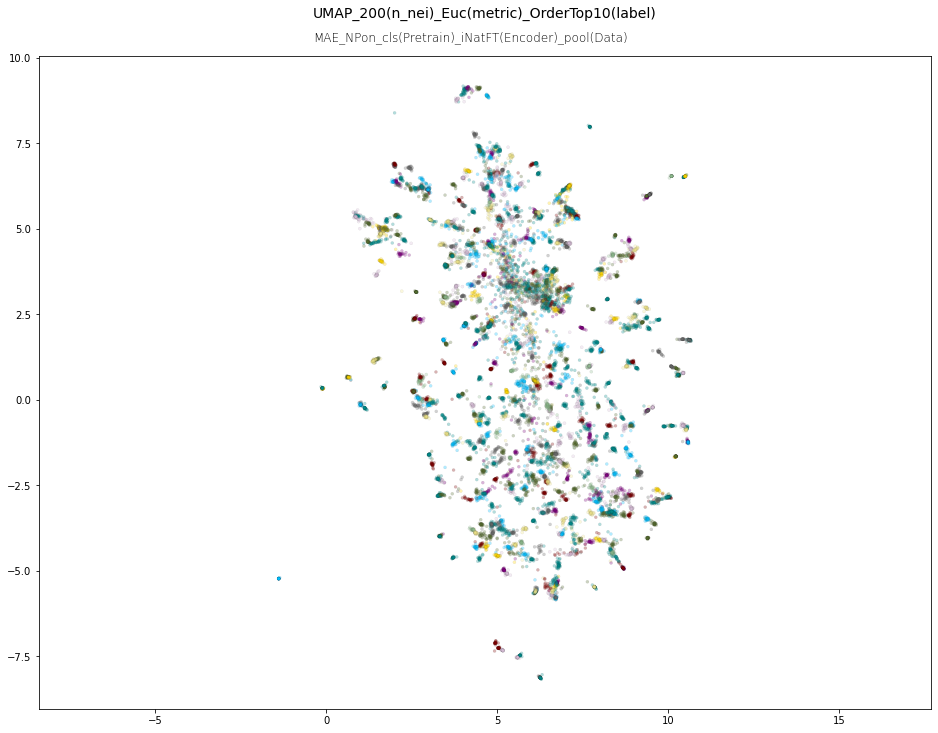

In [222]:
%%time

plot_Scatter2D(embedding_umap_pool[list(mask) + list(mask)], labels_pool, figsize=(16,12), size=10.0 ,alpha=0.3,
               save=True, title=title, v_model_data=v_model_data,
              )

### 以單色凸顯個別類群

In [223]:
# plot by class
save_path = Path('embedding/umap_color1')
save_path.mkdir(exist_ok=True)

def plot_2d_byCls(embedding:np.array, df_meta:pd.DataFrame,
                  cls_:str, taxon:str='order',
                  figsize:tuple=(16,12) ,size:float=15, alpha=0.7,
                  save:bool=True, save_path=save_path,  
                  **kwds
                 )->None:
    fig, ax = plt.subplots(figsize=figsize)

    # 取得單一類別的index位置 
    idx_cls_ = df_meta[df_meta[taxon] == cls_].index.values

    # 建立所有類別的scatter底圖
    ax.scatter(embedding[:, 0], embedding[:, 1], 
                c='lightgrey', lw=size*0.005, s=size*0.7, edgecolors='black', alpha=alpha*0.7)

    # 建立單一欲顯色的類別scatter圖
    scatter = ax.scatter(embedding[idx_cls_, 0], embedding[idx_cls_, 1],
                         c=labels[idx_cls_],
                         lw=size*0.01, s=size, edgecolors='black', cmap='Spectral', alpha=alpha)

    # 取出legen元素，圖標 handles與 標籤labels
    handles, labls = scatter.legend_elements()  # labels
    # family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
    ax.legend(
    #     *scatter.legend_elements(),
        handles=handles, 
        labels= [cls_] ,
        title=taxon, ncol=2, markerscale=1, fontsize=12)

    plt.title(title, y=1.03, fontsize=16)
    plt.suptitle(v_model_data, y=0.9, fontsize=12, fontweight='light')
    plt.gca().set_aspect('equal', 'datalim')
    if save==True:
        fig.savefig(Path(save_path)/f'{n_components}D_{title}_Color1_{v_model_data}.jpg', bbox_inches='tight',)
    ;



In [224]:
title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{order_.capitalize()}(label)'
print(title)

v_model_data = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
print(v_model_data)

print(embedding_umap_pool.shape)
df_meta_pool = pd.concat([df_meta, df_meta])
print(len(df_meta_pool))

taxon = 'order' 

UMAP_200(n_nei)_Euc(metric)_Trogoniformes(label)
MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
(29720, 2)
29720


In [225]:
%%time

taxon = 'order' 
order_list = list(df_meta.groupby(['order']).id.count()
                .sort_values(ascending=False)[:20].index)

save_path = Path(f'embedding/umap_color1/{encoder_version}_{taxon}')
save_path.mkdir(exist_ok=True)

for order_ in order_list:
    title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{order_.capitalize()}(label)'
    plot_2d_byCls(embedding_umap_pool, df_meta_pool, order_, taxon='order',
              figsize=(16,12), size =15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 5.23 s, sys: 2.71 s, total: 7.95 s
Wall time: 4.25 s


In [226]:
%%time

taxon = 'family' 
family_list = list(df_meta.groupby(['family']).id.count()
                .sort_values(ascending=False)[:30].index)

save_path = Path(f'embedding/umap_color1/{encoder_version}_{taxon}')
save_path.mkdir(exist_ok=True)

for family_ in family_list:
    title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{family_.capitalize()}(label)'
    plot_2d_byCls(embedding_umap_pool, df_meta_pool, family_, taxon='family',
              figsize=(16,12), size =15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 7.39 s, sys: 4.28 s, total: 11.7 s
Wall time: 6.12 s


# Interpolate latent space, decoding back to image


### run one sample

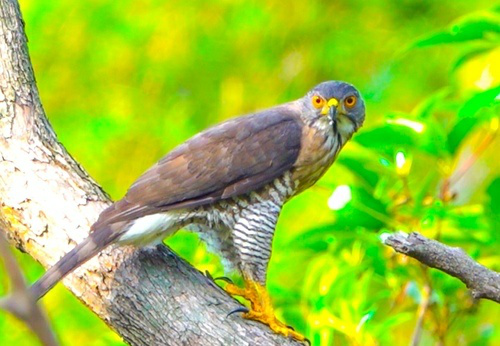

In [229]:
file = '../../share/iNaturalist_2021/val/03116_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_trivirgatus/6987197a-6702-497b-b57a-4eb3b9e14ee6.jpg'
img = Image.open(file)
img


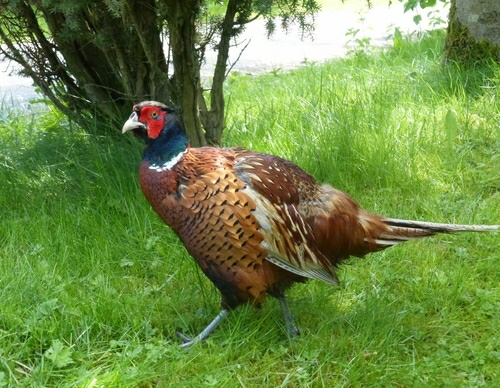

In [230]:
file = '../../share/iNaturalist_2021/val/03637_Animalia_Chordata_Aves_Galliformes_Phasianidae_Phasianus_colchicus/dba9545d-d38a-4c51-ab5e-6ea23cd4340e.jpg'
img2 = Image.open(file)
img2

In [231]:
# imagenet_mean = np.array([0.485, 0.456, 0.406])
# imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    image = image.detach().cpu()
    image = torch.einsum('nchw->hwc', image)
    assert image.shape[2] == 3
    
    plt.imshow(torch.clip((image) * 255, 0, 255).int())
    # plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def img2tensor(img:Image):
    img_ = img.resize((224, 224))
    img_ = np.array(img_) / 255.
    x = torch.tensor(img_)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x).float()
    return x


#### load MAE model for reconstruction imgs

In [235]:
# load model for reconstruction imgs
model = models_mae.__dict__['mae_vit_base_patch16'](norm_pix_loss=True)

# model_cp = 'output_dir/ebird_pretrain_1600_NPon_vit_base.pth' 
model_cp = 'output_dir/ebird_pretrain_1174_NPOff_vit_base.pth'
checkpoint = torch.load(model_cp, map_location='cpu')

print(f"Load pre-trained checkpoint from: {model_cp}")
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()

# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)

model.load_state_dict(checkpoint_model)
# model

Load pre-trained checkpoint from: output_dir/ebird_pretrain_1174_NPOff_vit_base.pth


<All keys matched successfully>

In [ ]:
[k for k, v in model.named_children()]
# [k for k in model.named_modules()]
# model.modules()


In [ ]:
# # Load LP model as MAE Encoder

# encoder = 'lp'
# ck_ft = 'ebird_FT_cls_vit_base_checkpoint-99.pth'
# ck_lp = 'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'
# ck = ck_lp if encoder=='lp' else ck_ft
# checkpoint = torch.load(ck, map_location='cpu')

# print(f"Load pre-trained checkpoint from: {ck_lp}")
# checkpoint_model = checkpoint['model']

# state_dict = model.state_dict()

# # interpolate position embedding
# interpolate_pos_embed(model, checkpoint_model)

# # load pre-trained model
# msg = model.load_state_dict(checkpoint_model, strict=False)
# print(msg)

In [246]:
seed = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

embeddings = []
rec_imgs = []
ids_restores = []
for img_ in [img, img2]:
    x_ = img2tensor(img_).to(device)
    
    # for geting identical ids_restore
    torch.manual_seed(seed)
    
    embedding_, mask_, ids_restore_ = model.forward_encoder(x_, mask_ratio=0)
    ids_restores.append(ids_restore_)
    embedding_ = embedding_
    embeddings.append(embedding_.detach().cpu())
    pred_ = model.forward_decoder(embedding_, ids_restore_)
    rec_img_ = model.unpatchify(pred_)
    rec_imgs.append(rec_img_)
    
print(ids_restores[0], '\n', ids_restores[1])
assert (ids_restores[0] == ids_restores[1]).all(), "ids_restores not equal"


tensor([[173,   5, 175, 109, 147, 176,  67,   8, 130,   3, 185, 111,  34, 119,
         135,  61, 157, 110,  24, 140, 141, 148,  91,  20,  96,  85,   1,  57,
         149, 189,  38,  79,  66,  68,  60,   0,  92, 181,  53,  29,  21,  36,
         186,  33,  13, 128,  49,  90,  18,  58, 172,   2,  26, 144, 117, 103,
         188, 123,  93,  30, 165,  97,  50,  77,  71,  62, 192, 178,  28,  44,
         115,  43,  75,  42,  70, 112, 170, 152, 145,  25, 129,  76, 159, 166,
         116, 161,   6,  39,   4,  14,  45, 102,  40, 139,  89, 137, 179, 151,
         143,  59,  12,  11,  10,  74, 168, 190, 184, 182,  82,  80,  87, 105,
           7,  41,  51,  88, 125,   9,  32, 133,  23, 158,  37,  55,  83, 177,
         142,  94, 127,  99, 106, 113, 171, 191, 163,  48, 104, 118,  46, 108,
          65,  69, 138,  47,  63,  73, 126,  98, 153, 132, 187,  17, 131,  27,
         193, 155,  86, 154,  84,  19, 156, 160,  81, 150, 180, 194, 100, 120,
         183, 136, 101,  22,  15,  78, 146, 124,  52

In [238]:
save_path = Path('meta')
vutils.save_image(torch.cat(rec_imgs), save_path/'rec_imgs_NPoff.jpg', nrow=2, padding=2, normalize=False)
vutils.save_image(torch.cat(rec_imgs), save_path/'rec_imgs_norm_NPoff.jpg', nrow=2, padding=2, normalize=True)

#### reconstruction imgs
- rec_imgs_normalize  
![rec_imgs_normalize](meta/rec_imgs_normalize.jpg)  


- rec_imgs  
![rec_imgs_normalize](meta/rec_imgs.jpg)


In [247]:
num_inter = 20
num_patch, num_dim = embeddings[0].squeeze(dim=0).shape

interpolate_embedding = []

for idx_d, dim in enumerate(range(num_dim)) :
    emb0_d = embeddings[0].squeeze(dim=0)[:,dim]  # torch.Size([197])
    emb1_d = embeddings[1].squeeze(dim=0)[:,dim]  # torch.Size([197])
    
    interpolate_patch = []
    for idx_p, p in enumerate(range(num_patch)):
        # if p==0 :   # skip pos_embedding
        #     continue
        interpolat_p_ = torch.linspace(emb0_d[p], emb1_d[p], num_inter)
        interpolate_patch.append(interpolat_p_)
        
    interpolate_patch = torch.einsum('pi->ip', torch.stack(interpolate_patch))
    interpolate_embedding.append(interpolate_patch)
    print(f'dim : {dim}, {len(interpolate_patch)}. | patch : {p}, {interpolate_patch.shape}', end='\r')
    

# (768, 24, 197) embedding, interpolate_patch, patches > (24, 197, 768)
interpolate_embedding = torch.einsum('eip->ipe', torch.stack(interpolate_embedding)) 
print('\n',interpolate_embedding.shape)
    

dim : 767, 20. | patch : 196, torch.Size([20, 197])
 torch.Size([20, 197, 768])


In [254]:
embedding_.to(device)

tensor([[-0.0741, -0.0397,  0.1014,  ..., -0.0339, -0.1662,  0.0934],
        [-0.0597,  0.1561, -0.1646,  ..., -0.1647,  0.1482, -0.0809],
        [-0.2559, -0.1193,  0.1212,  ..., -0.1324, -0.0798,  0.5216],
        ...,
        [-0.4352, -0.0603,  0.1031,  ...,  0.0336, -0.2015,  0.1518],
        [-0.1135, -0.4185,  0.1753,  ..., -0.0899,  0.2565,  0.3366],
        [-0.6359,  0.5294,  0.1517,  ..., -0.1264,  0.3234,  0.2312]],
       device='cuda:0')

In [255]:
# reconstruct interpolated images


assert (ids_restores[0] == ids_restores[1]).all(), "ids_restores not equal"
ids_restore_ = ids_restores[0]

rec_interpolated_imgs = [] 

for i , embedding_ in enumerate(interpolate_embedding):
    print(i, embedding_.shape, end='\r')
    pred_ = model.forward_decoder(embedding_.unsqueeze(dim=0).to(device), ids_restore_.to(device))
    rec_img_ = model.unpatchify(pred_)
    rec_interpolated_imgs.append(rec_img_)

rec_interpolated_imgs = torch.stack(rec_interpolated_imgs).squeeze(dim=1)
print(rec_interpolated_imgs.shape)


torch.Size([20, 3, 224, 224])


In [256]:
save_path = Path('meta')
nrow=int(num_inter/4)
vutils.save_image(rec_interpolated_imgs , save_path/'interpolate_rec_imgs_NPoff.jpg', nrow=nrow, padding=1, normalize=False)
vutils.save_image(rec_interpolated_imgs , save_path/'interpolate_rec_imgs_norm_NPoff.jpg', nrow=nrow, padding=1, normalize=True)

---

# Exploring Embeddings

In [ ]:
# Exploring Position Embedding
pd.DataFrame(model.pos_embed.mean(dim=1)).T.plot(title='mean_dim', figsize=(9,3));
pd.DataFrame(model.pos_embed.std(dim=1)).T.plot(title='std_dim', figsize=(9,3));

In [ ]:
pd.DataFrame(model.pos_embed.mean(dim=2)).T[1:].plot(title='mean_patch', figsize=(9,3));
pd.DataFrame(model.pos_embed.std(dim=2)).T[1:].plot(title='std_patch', figsize=(9,3));

In [260]:
for i in range(1):
    print(i)

0
